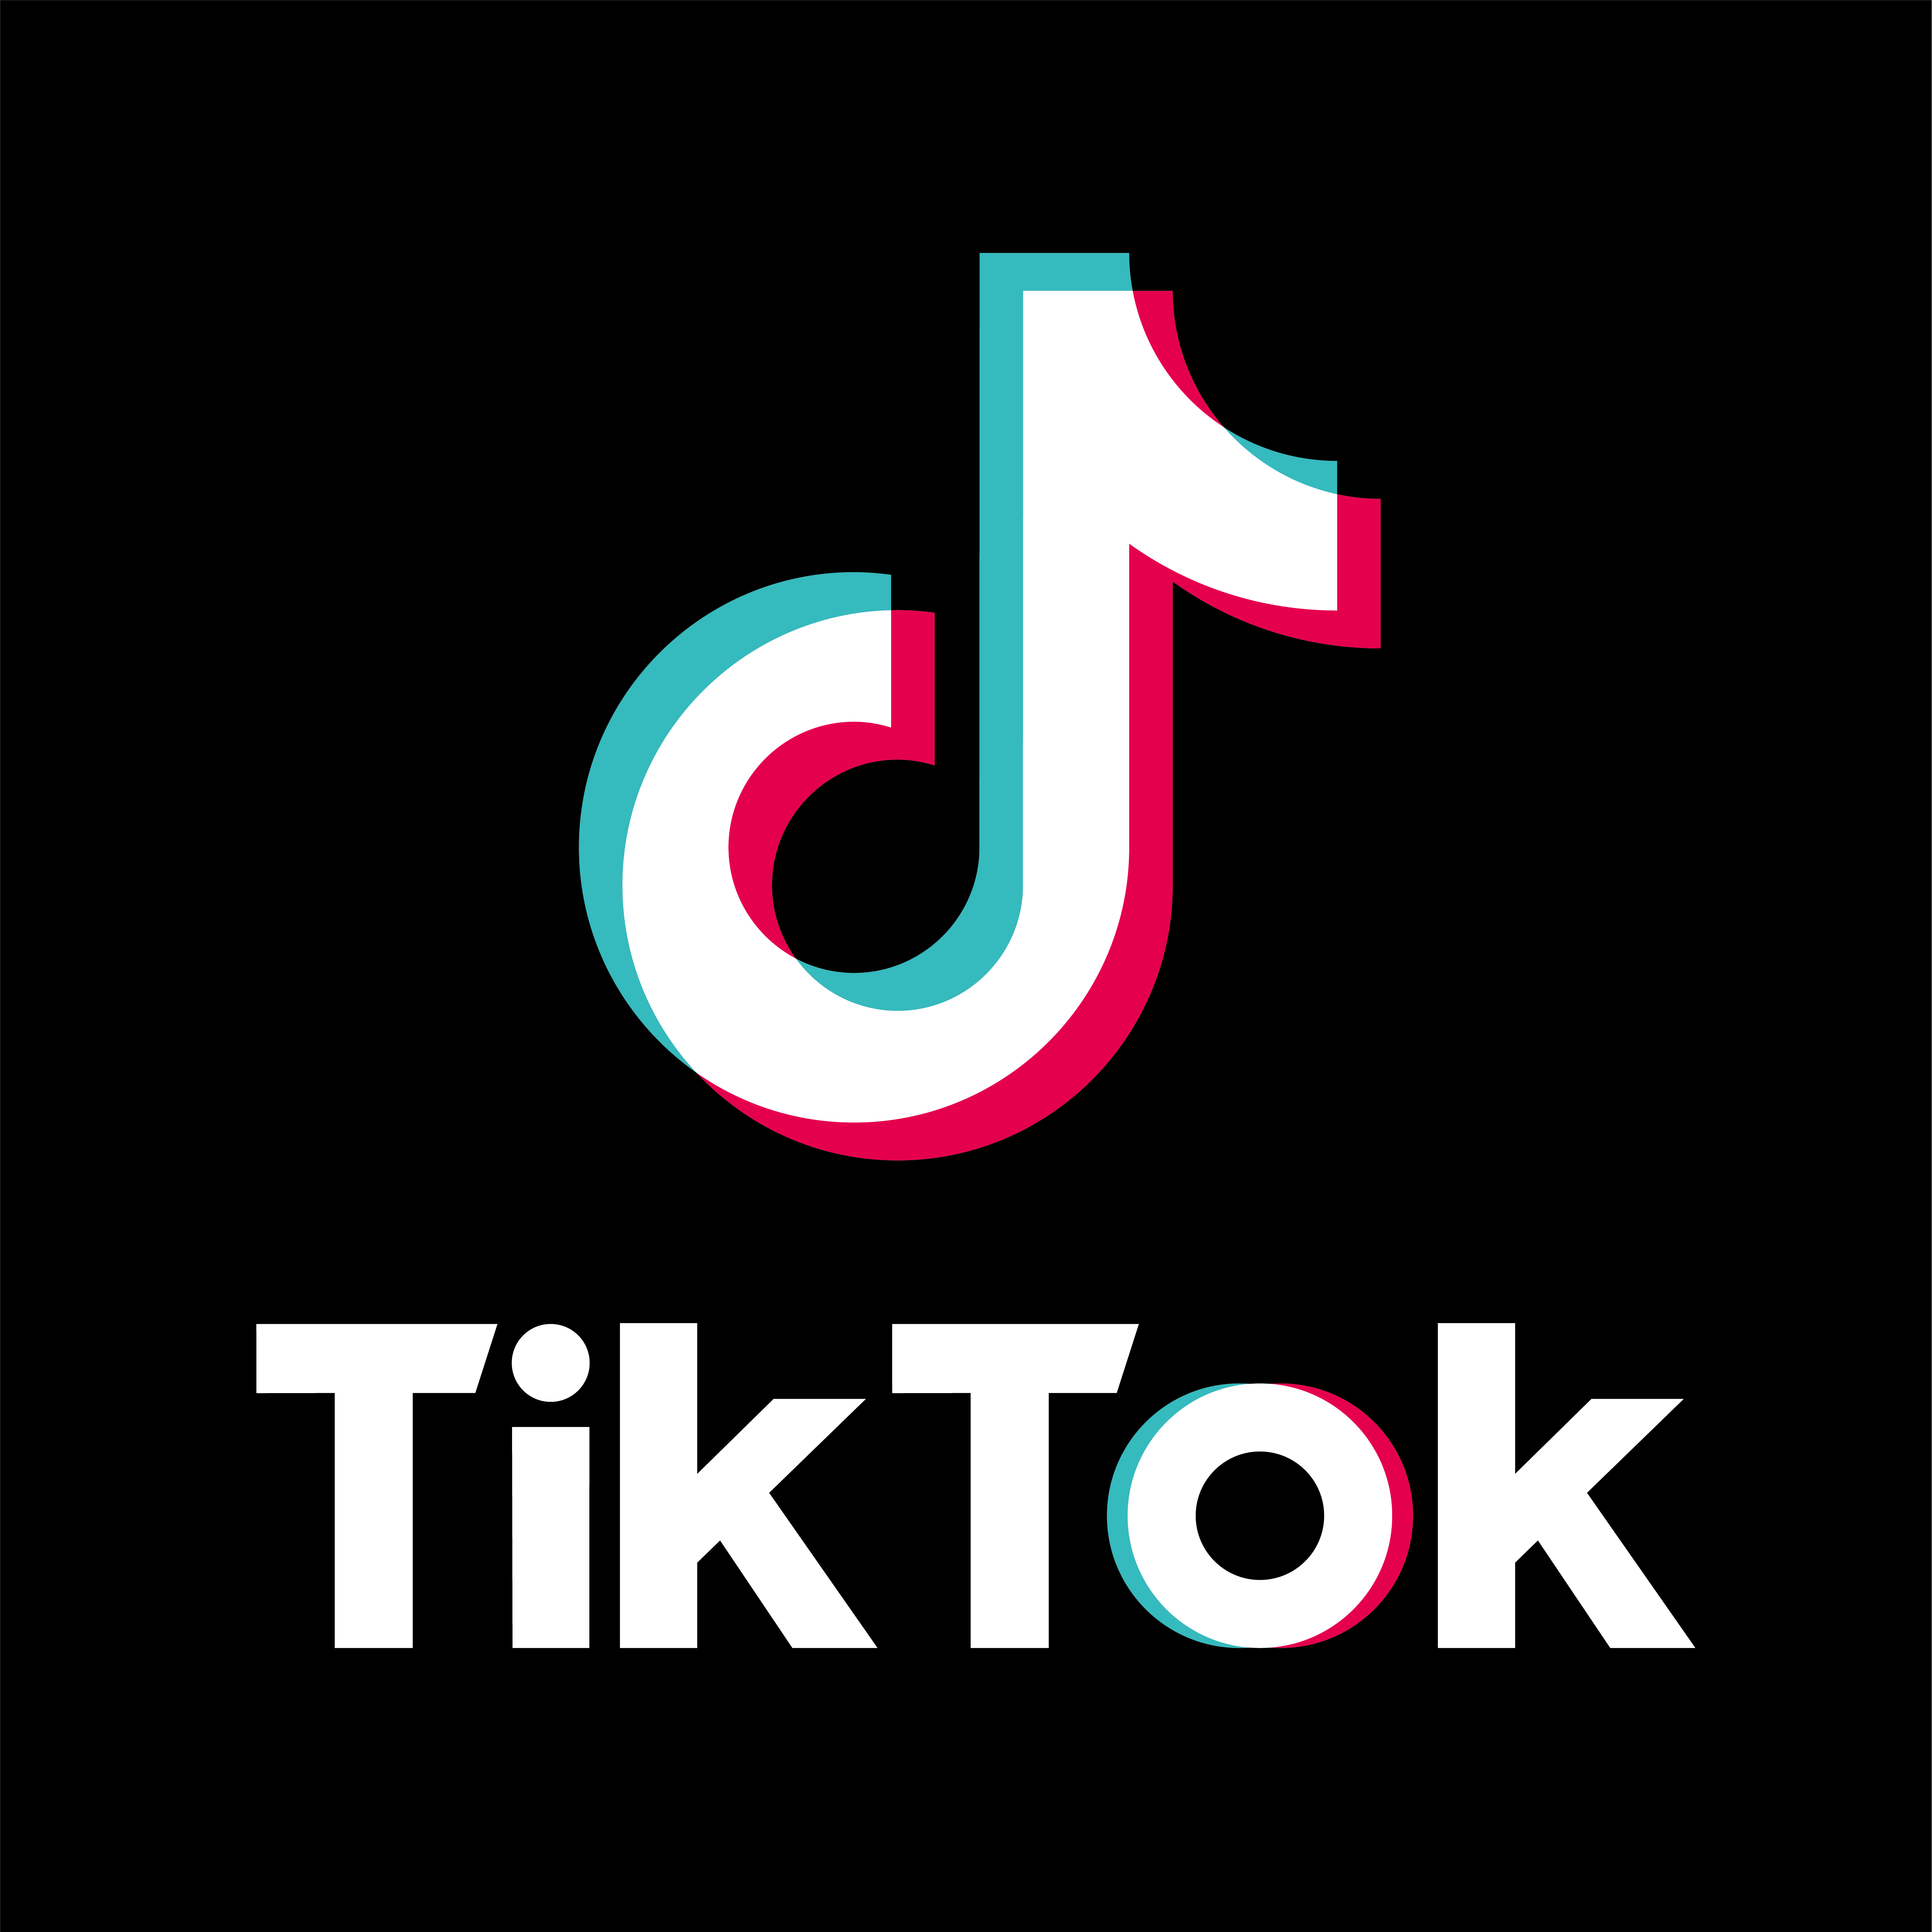

### SUMMARY

- **[Inspect and Analyze Data](#1)**
- **[Exploratory Data Analysis](#2)**
- **[Hypothesis Testing](#3)**
- **[Regression Modeling](#4)**
- **[Machine Learning for Video Classification](#5)**

TikTok allows users to report videos and comments that may contain claims or opinions requiring moderator review. This results in a high volume of reports, making it difficult to process them efficiently.

To address this, TikTok is developing a predictive model that can automatically determine whether a video presents a claim or an opinion. By leveraging this model, the platform aims to streamline moderation efforts, reduce backlog, and prioritize reports more effectively.

# 1. Inspect and Analyze Data
<a id="1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.utils import resample

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,accuracy_score, \
precision_score,recall_score,f1_score

from xgboost import XGBClassifier
from xgboost import plot_importance

import warnings
warnings.filterwarnings("ignore")

**Read the Data**

In [2]:
data = pd.read_csv("/kaggle/input/tiktok-dataset/tiktok_dataset.csv")

data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [4]:
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


Upon reviewing the first few rows of the dataset, it is evident that the data consists of categorical, text, and numerical variables. Each row corresponds to a unique TikTok video containing either a claim or an opinion, along with relevant metadata. Examining the output of data.info(), it is observed that the dataset comprises both numeric and non-numeric variables, with seven columns, including "claim_status," containing null values. Further analysis using data.describe() reveals that some variables have high standard deviations and maximum values, suggesting the presence of potential outliers. Additionally, investigating the "claim_status" column provides insight into the distribution of different claim types and their respective frequencies within the dataset.

**Understand the data - Investigate the variables**

In [5]:
data['claim_status'].value_counts()

claim_status
claim      9608
opinion    9476
Name: count, dtype: int64

Average view count of videos with "claim" status .

In [6]:
claims = data[data['claim_status'] == 'claim']

print('Mean view count claims:',claims['video_view_count'].mean())
print('Median view count claims:',claims['video_view_count'].median())

Mean view count claims: 501029.4527477102
Median view count claims: 501555.0


Average view count of videos with "opinion" status.

In [7]:
opinions = data[data['claim_status'] == 'opinion']

print('Mean view count opinions:',opinions['video_view_count'].mean())
print('Median view count opinions:',opinions['video_view_count'].median())

Mean view count opinions: 4956.43224989447
Median view count opinions: 4953.0


Get counts for each group combination of claim status and author ban status.

In [8]:
data.groupby(by=['claim_status','author_ban_status']).count()

#  video_id  video_duration_sec  \
claim_status author_ban_status                                       
claim        active             6566      6566                6566   
             banned             1439      1439                1439   
             under review       1603      1603                1603   
opinion      active             8817      8817                8817   
             banned              196       196                 196   
             under review        463       463                 463   

                                video_transcription_text  verified_status  \
claim_status author_ban_status                                              
claim        active                                 6566             6566   
             banned                                 1439             1439   
             under review                           1603             1603   
opinion      active                                 8817             8817   
             banned                                  196              196   
             under review                            463              463   

                                video_view_count  video_like_count  \
claim_status author_ban_status                                       
claim        active                         6566              6566   
             banned                         1439              1439   
             under review                   1603              1603   
opinion      active                         8817              8817   
             banned                          196               196   
             under review                    463               463   

                                video_share_count  video_download_count  \
claim_status author_ban_status                                            
claim        active                          6566                  6566   
             banned                          1439                  1439   
             under review                    1603                  1603   
opinion      active                          8817                  8817   
             banned                           196                   196   
             under review                     463                   463   

                                video_comment_count  
claim_status author_ban_status                       
claim        active                            6566  
             banned                            1439  
             under review                      1603  
opinion      active                            8817  
             banned                             196  
             under review                       463

Continue investigating engagement levels, now focusing on author_ban_status.

Calculate the median video share count of each author ban status.

In [9]:
data.groupby(['author_ban_status'])['video_share_count'].median()

author_ban_status
active            437.0
banned          14468.0
under review     9444.0
Name: video_share_count, dtype: float64

Use groupby() to group the data by author_ban_status, then use agg() to get the count, mean, and median of each of the following columns:

1. video_view_count
2. video_like_count
3. video_share_count

In [10]:
data.groupby(['author_ban_status']).agg({'video_view_count':['count','mean','median'],
    'video_like_count':['count','mean','median'],'video_share_count':['count','mean','median']})

video_view_count                          video_like_count  \
                             count           mean    median            count   
author_ban_status                                                              
active                       15383  215927.039524    8616.0            15383   
banned                        1635  445845.439144  448201.0             1635   
under review                  2066  392204.836399  365245.5             2066   

                                           video_share_count                \
                            mean    median             count          mean   
author_ban_status                                                            
active              71036.533836    2222.0             15383  14111.466164   
banned             153017.236697  105573.0              1635  29998.942508   
under review       128718.050339   71204.5              2066  25774.696999   

                            
                    median  
author_ban_status           
active               437.0  
banned             14468.0  
under review        9444.0

Banned authors and those under review get far more views, likes, and shares than active authors. <br>
In most groups, the mean is much greater than the median, which indicates that there are some videos with very high engagement counts.

Now, create three new columns to help better understand engagement rates:

1. likes_per_view: represents the number of likes divided by the number of views for each video
2. comments_per_view: represents the number of comments divided by the number of views for each video
3. shares_per_view: represents the number of shares divided by the number of views for each video

In [11]:
# Create a likes_per_view column
data['likes_per_view'] = data['video_like_count'] / data['video_view_count']

# Create a comments_per_view column
data['comments_per_view'] = data['video_comment_count'] / data['video_view_count']

# Create a shares_per_view column
data['shares_per_view'] = data['video_share_count'] / data['video_view_count']

data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,0.056584,0.000000,0.000702
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,0.549096,0.004855,0.135111
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,0.108282,0.000365,0.003168
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,0.548459,0.001335,0.079569
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,0.622910,0.002706,0.073175


Use groupby() to compile the information in each of the three newly created columns for each combination of categories of claim status and author ban status, then use agg() to calculate the count, the mean, and the median of each group.

In [12]:
data.groupby(by=['claim_status','author_ban_status']).agg(
    {'likes_per_view': ['count', 'mean', 'median'],
     'comments_per_view': ['count', 'mean', 'median'],
     'shares_per_view': ['count', 'mean', 'median']})

likes_per_view                      \
                                        count      mean    median   
claim_status author_ban_status                                      
claim        active                      6566  0.329542  0.326538   
             banned                      1439  0.345071  0.358909   
             under review                1603  0.327997  0.320867   
opinion      active                      8817  0.219744  0.218330   
             banned                       196  0.206868  0.198483   
             under review                 463  0.226394  0.228051   

                               comments_per_view                      \
                                           count      mean    median   
claim_status author_ban_status                                         
claim        active                         6566  0.001393  0.000776   
             banned                         1439  0.001377  0.000746   
             under review                   1603  0.001367  0.000789   
opinion      active                         8817  0.000517  0.000252   
             banned                          196  0.000434  0.000193   
             under review                    463  0.000536  0.000293   

                               shares_per_view                      
                                         count      mean    median  
claim_status author_ban_status                                      
claim        active                       6566  0.065456  0.049279  
             banned                       1439  0.067893  0.051606  
             under review                 1603  0.065733  0.049967  
opinion      active                       8817  0.043729  0.032405  
             banned                        196  0.040531  0.030728  
             under review                  463  0.044472  0.035027

# 2. Exploratory Data Analysis 
<a id="2"></a>

## 2.1 Build Visualizations

**Video duration**

Create a box plot to examine the spread of values in the *video_duration_sec* column and a histogram to further explore the distribution of this variable.

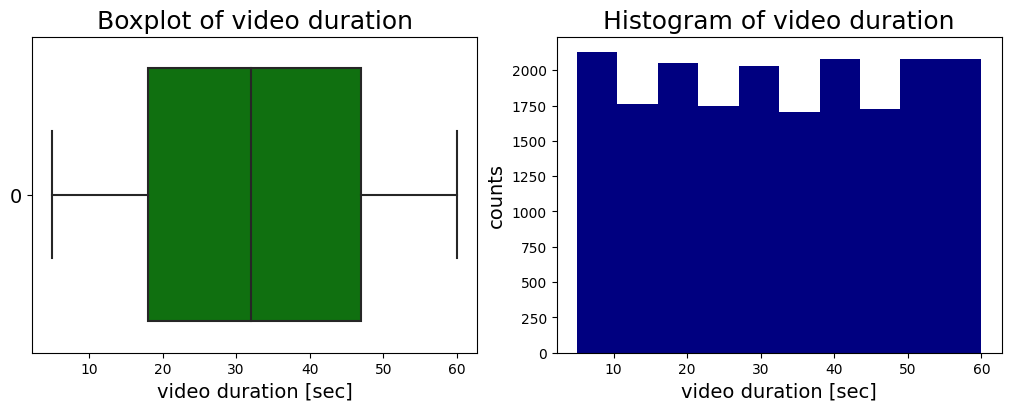

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4),constrained_layout = True)

ax1 = sns.boxplot(data=data,x='video_duration_sec',color='g',ax=ax1)
ax1.set_xlabel("video duration [sec]",fontsize=14)
ax1.set_title('Boxplot of video duration',fontsize=18)
ax1.set_yticklabels(ax1.get_yticks(),size=14)

ax2 = plt.hist(data['video_duration_sec'],bins=10,color='navy')
plt.xlabel('video duration [sec]',fontsize=14)
plt.ylabel('counts',fontsize=14)
plt.title('Histogram of video duration',fontsize=18);

What do you notice about the duration and distribution of the videos?

*It is an almost uniform distribution, with durations ranging from 3 to 60 secs*.

**Video view count**

Create a box plot to examine the spread of values in the *video_view_count* column and a histogram of the values to further explore the distribution of this variable.

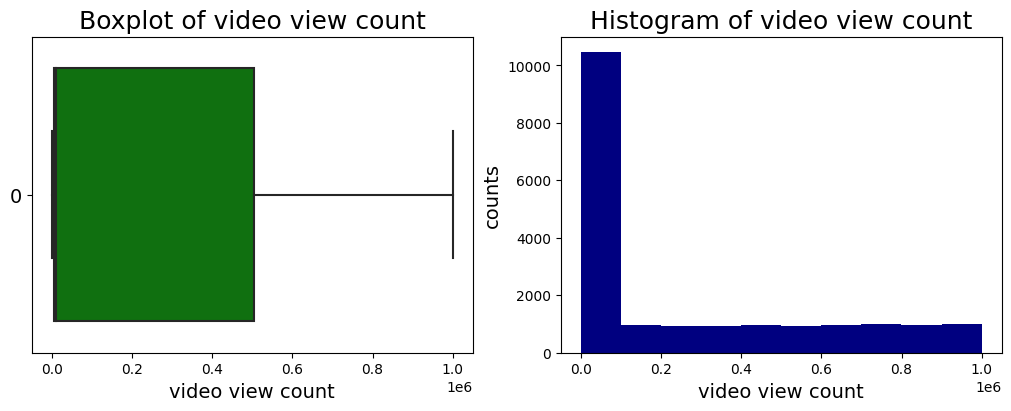

In [14]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4),constrained_layout = True)

ax1 = sns.boxplot(data=data,x='video_view_count',color='g',ax=ax1)
ax1.set_xlabel("video view count",fontsize=14)
ax1.set_title('Boxplot of video view count',fontsize=18)
ax1.set_yticklabels(ax1.get_yticks(),size=14)

ax2 = plt.hist(data['video_view_count'],bins=10,color='navy')
plt.xlabel('video view count',fontsize=14)
plt.ylabel('counts',fontsize=14)
plt.title('Histogram of video view count',fontsize=18);

What do you notice about the distribution of this variable?

*There is a peak in the right distribution, with videos with more than 100K views. After that, the distibution is almost uniform.*

**Video like count**

Create a box plot to examine the spread of values in the *video_like_count* column and a histogram of the values to further explore the distribution of this variable.

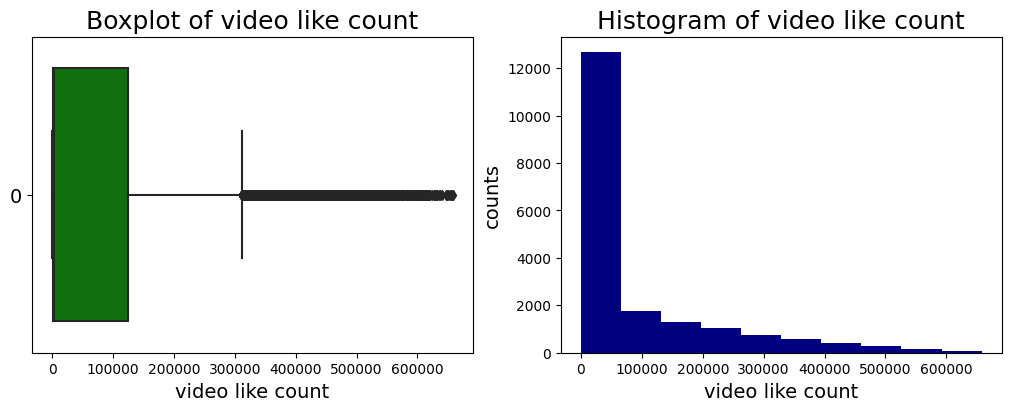

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4),constrained_layout = True)

ax1 = sns.boxplot(data=data,x='video_like_count',color='g',ax=ax1)
ax1.set_xlabel("video like count",fontsize=14)
ax1.set_title('Boxplot of video like count',fontsize=18)
ax1.set_yticklabels(ax1.get_yticks(),size=14)

ax2 = plt.hist(data['video_like_count'],bins=10,color='navy')
plt.xlabel('video like count',fontsize=14)
plt.ylabel('counts',fontsize=14)
plt.title('Histogram of video like count',fontsize=18);

What do you notice about the distribution of this variable?

*First, I notice the large number of 'right' outliers (see the boxplot), representing videos with huge amounts of likes. The second plot shows that the distibution has a high peak (less than 100K likes) and that the rest of the distribution (representing videos with more than 100K likes) slowly decreases towards 0.*

**Video comment count**

Create a box plot to examine the spread of values in the *video_comment_count* column and a histogram of the values to further explore the distribution of this variable.

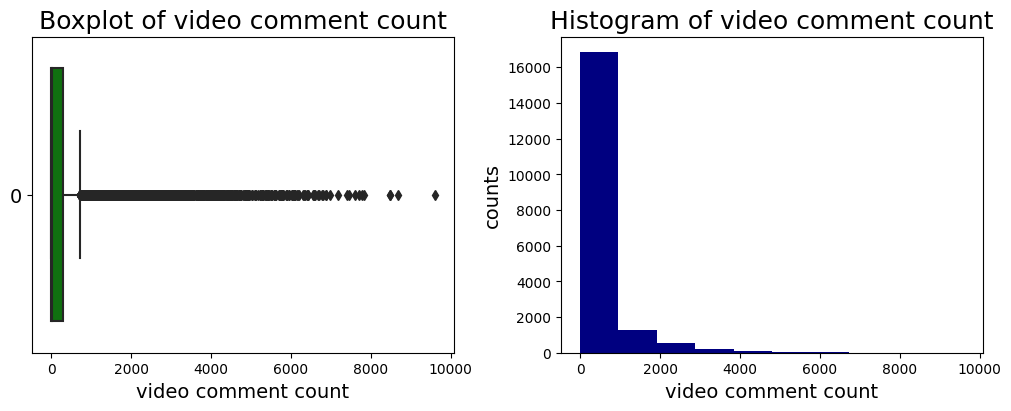

In [16]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4),constrained_layout = True)

ax1 = sns.boxplot(data=data,x='video_comment_count',color='g',ax=ax1)
ax1.set_xlabel("video comment count",fontsize=14)
ax1.set_title('Boxplot of video comment count',fontsize=18)
ax1.set_yticklabels(ax1.get_yticks(),size=14)

ax2 = plt.hist(data['video_comment_count'],bins=10,color='navy')
plt.xlabel('video comment count',fontsize=14)
plt.ylabel('counts',fontsize=14)
plt.title('Histogram of video comment count',fontsize=18);

What do you notice about the distribution of this variable?

*The distributions are not so different from those of video_like_count. The boxplot shows many 'right' outliers and the histogram is peaked at around 1000 comments or less. Videos with many comments are few.*

**Video share count**

Create a box plot to examine the spread of values in the *video_share_count* column and a histogram of the values to further explore the distribution of this variable.

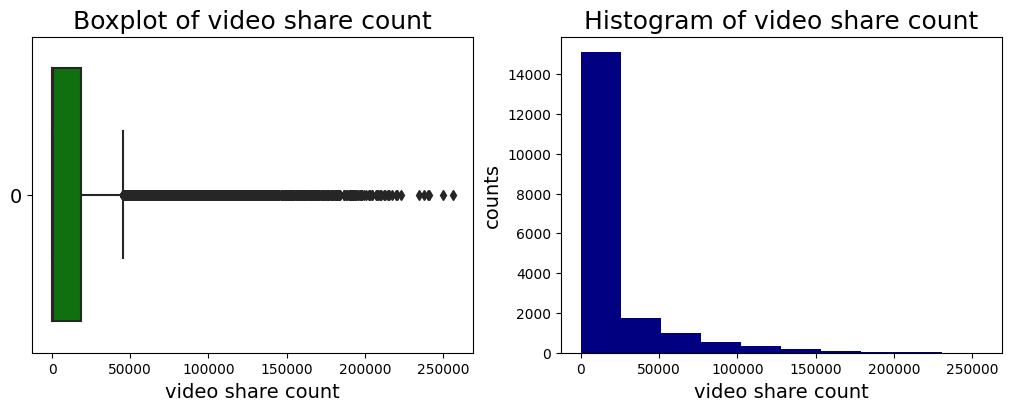

In [17]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4),constrained_layout = True)

ax1 = sns.boxplot(data=data,x='video_share_count',color='g',ax=ax1)
ax1.set_xlabel("video share count",fontsize=14)
ax1.set_title('Boxplot of video share count',fontsize=18)
ax1.set_yticklabels(ax1.get_yticks(),size=14)

ax2 = plt.hist(data['video_share_count'],bins=10,color='navy')
plt.xlabel('video share count',fontsize=14)
plt.ylabel('counts',fontsize=14)
plt.title('Histogram of video share count',fontsize=18);

What do you notice about the distribution of this variable?

*As before, the majority of videos do not have many shares. Very few are shared massively.*

**Video download count**

Create a box plot to examine the spread of values in the *video_download_count* column and a histogram of the values to further explore the distribution of this variable.

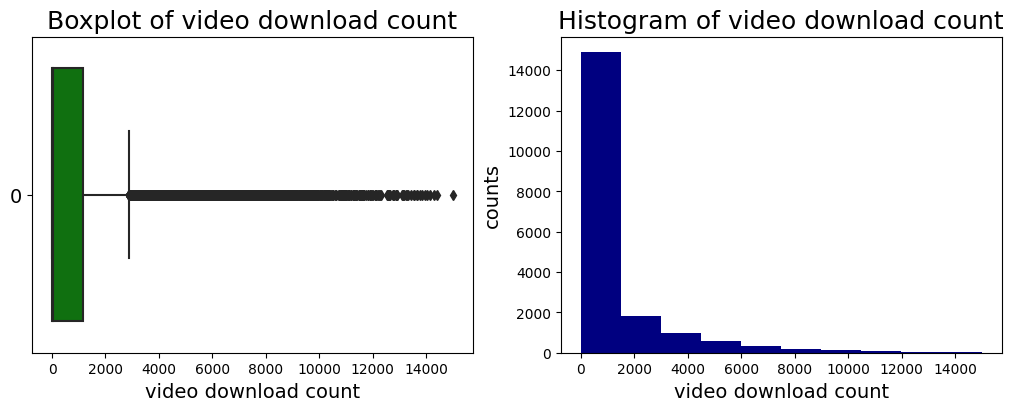

In [18]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4),constrained_layout = True)

ax1 = sns.boxplot(data=data,x='video_download_count',color='g',ax=ax1)
ax1.set_xlabel("video download count",fontsize=14)
ax1.set_title('Boxplot of video download count',fontsize=18)
ax1.set_yticklabels(ax1.get_yticks(),size=14)

ax2 = plt.hist(data['video_download_count'],bins=10,color='navy')
plt.xlabel('video download count',fontsize=14)
plt.ylabel('counts',fontsize=14)
plt.title('Histogram of video download count',fontsize=18);

What do you notice about the distribution of this variable?

*Again, the distribution is very skewed. The boxplot shows the presence of many outliers.*

**Claim status by verification status & author ban status**

Now, create: 
1. A histogram with four bars: one for each combination of claim status and verification status.
2. A histogram to communicate the same information, but for claim status by author ban status.

Text(0.5, 1.0, 'Histplot of claim status vs verification status')

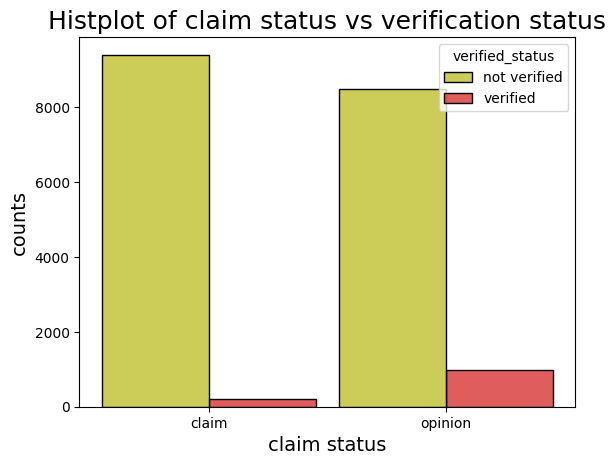

In [19]:
sns.histplot(data=data,x='claim_status',hue='verified_status',multiple='dodge',shrink=0.9,palette=["C8","C13"])

plt.xlabel("claim status",fontsize=14)
plt.ylabel("counts",fontsize=14)
plt.title('Histplot of claim status vs verification status',fontsize=18)

What do you notice about the number of verified users compared to unverified? And how does that affect their likelihood to post opinions?

*The number of verified users is much smaller. Because of their motivation (of getting the 'verified status'), they post more opinions compared to the users who are not verified.*

Text(0.5, 1.0, 'Histplot of claim status vs author ban status')

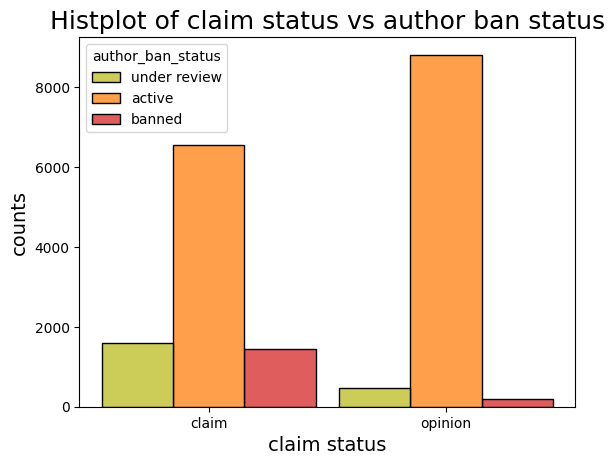

In [20]:
sns.histplot(data=data,x='claim_status',hue='author_ban_status',multiple='dodge',shrink=0.9,palette=["C8","C1","C13"])

plt.xlabel("claim status",fontsize=14)
plt.ylabel("counts",fontsize=14)
plt.title('Histplot of claim status vs author ban status',fontsize=18)

What do you notice about the number of active authors compared to banned authors for both claims and opinions?

*The proportion of active authors is higher on the opinion side. This means that, when posting claim videos, the probability of being under review or getting banned is much higher.*

**Median view counts by ban status**

Create a bar plot with three bars: one for each author ban status. The height of each bar should correspond with the median number of views for all videos with that author ban status.

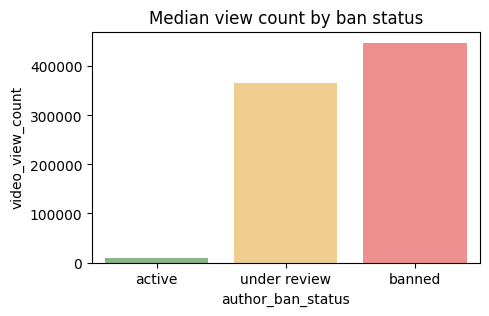

In [21]:
ban_status_counts = data.groupby(['author_ban_status']).median(
    numeric_only=True).reset_index()

fig = plt.figure(figsize=(5,3))
sns.barplot(data=ban_status_counts,
            x='author_ban_status',
            y='video_view_count',
            order=['active', 'under review', 'banned'],
            palette={'active':'green', 'under review':'orange', 'banned':'red'},
            alpha=0.5)
plt.title('Median view count by ban status');

What do you notice about the median view counts for non-active authors compared to that of active authors? Based on that insight, what variable might be a good indicator of claim status?

*The median view counts for non-active authors are much larger than the median view count for active authors. Since you know that non-active authors are more likely to post claims, and that videos by non-active authors get far more views on aggregate than videos by active authors, then video_view_count might be a good indicator of claim status.*

Calculate the median view count for claim status.

In [22]:
data.groupby('claim_status')['video_view_count'].median()

claim_status
claim      501555.0
opinion      4953.0
Name: video_view_count, dtype: float64

**Total views by claim status**

Create a pie graph that depicts the proportions of total views for claim videos and total views for opinion videos.

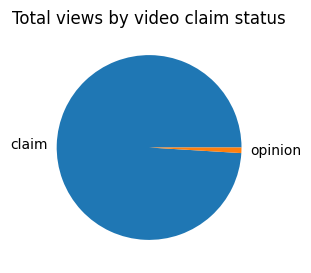

In [23]:
fig = plt.figure(figsize=(3,3))
plt.pie(data.groupby('claim_status')['video_view_count'].sum(), labels=['claim', 'opinion'])
plt.title('Total views by video claim status');

What do you notice about the overall view count for claim status?

*The overall view count is dominated by claim videos.*

**Determine outliers**

When building predictive models, the presence of outliers can be problematic. For example, if you were trying to predict the view count of a particular video, videos with extremely high view counts might introduce bias to a model. Also, some outliers might indicate problems with how data was captured or recorded. <br>
A common way to determine outliers in a normal distribution is to calculate the interquartile range (IQR) and set a threshold that is 1.5 * IQR above the 3rd quartile.

In this TikTok dataset, the values for the count variables are not normally distributed. They are heavily skewed to the right. One way of modifying the outlier threshold is by calculating the median value for each variable and then adding 1.5 * IQR. This results in a threshold that is, in this case, much lower than it would be if you used the 3rd quartile.

Write a for loop that iterates over the column names of each count variable. For each iteration:

1. Calculate the IQR of the column
2. Calculate the median of the column
3. Calculate the outlier threshold (median + 1.5 * IQR)
4. Calculate the numer of videos with a count in that column that exceeds the outlier threshold
5. Print "Number of outliers, {column name}: {outlier count}"

In [24]:
count_cols = ['video_view_count',
              'video_like_count',
              'video_share_count',
              'video_download_count',
              'video_comment_count',
              ]

for column in count_cols:
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    median = data[column].median()
    outlier_threshold = median + 1.5*iqr

    # Count the number of values that exceed the outlier threshold
    outlier_count = (data[column] > outlier_threshold).sum()
    print(f'Number of outliers, {column}:', outlier_count)

Number of outliers, video_view_count: 2343
Number of outliers, video_like_count: 3468
Number of outliers, video_share_count: 3732
Number of outliers, video_download_count: 3733
Number of outliers, video_comment_count: 3882


**Scatterplot**

Create a scatterplot of *video_view_count* versus *video_like_count* according to *claim_status*. Then, create a scatterplot of video_view_count versus video_like_count for opinions only.

In [ ]:
sns.scatterplot(x=data["video_view_count"],y=data["video_like_count"],hue=data["claim_status"],s=10,alpha=.3)
plt.show()

In [ ]:
opinion = data[data['claim_status']=='opinion']
sns.scatterplot(x=opinion["video_view_count"],y=opinion["video_like_count"],s=10,alpha=.3)
plt.show()

# 3. Hypothesis Testing
<a id="3"></a>

**Missing values**

Check for missing values and drop rows with missing values.


In [ ]:
data.isna().sum()

In [ ]:
data.dropna(axis=0,inplace=True)

data.isna().sum()

You are interested in the relationship between *verified_status* and *video_view_count*. One approach is to examine the mean value of *video_view_count* for each group of *verified_status* in the sample data.

In [ ]:
data.groupby('verified_status')['video_view_count'].mean()

**Hypothesis test**

Recall the difference between the null hypothesis and the alternative hypotheses. What are your hypotheses for this data project?

**Null hypothesis.** *There is no difference in number of views between TikTok videos posted by verified accounts and TikTok videos posted by unverified accounts (any observed difference in the sample data is due to chance or sampling variability).* <br>
**Alternative hypothesis.** *There is a difference in number of views between TikTok videos posted by verified accounts and TikTok videos posted by unverified accounts (any observed difference in the sample data is due to an actual difference in the corresponding population means).*

Your goal in this step is to conduct a two-sample t-test. Recall the steps for conducting a hypothesis test:

1. State the null hypothesis and the alternative hypothesis
2. Choose a signficance level
3. Find the p-value
4. Reject or fail to reject the null hypothesis

$H_0$: There is no difference in number of views between TikTok videos posted by verified accounts and TikTok videos posted by unverified accounts (any observed difference in the sample data is due to chance or sampling variability).

$H_{\rm A}$: There is a difference in number of views between TikTok videos posted by verified accounts and TikTok videos posted by unverified accounts (any observed difference in the sample data is due to an actual difference in the corresponding population means).

You choose 5% as the significance level and proceed with a two-sample t-test.

In [ ]:
# Save each sample in a variable
not_verified = data[data["verified_status"] == "not verified"]["video_view_count"]
verified = data[data["verified_status"] == "verified"]["video_view_count"]

# Implement a t-test using the two samples
stats.ttest_ind(a=not_verified,b=verified,equal_var=False)

Based on the p-value you got above, do you reject or fail to reject the null hypothesis?

*Since the p-value is extremely small, we can reject the null hypothesis.*

# 4. Regression Modeling
<a id="4"></a>

**Check for duplicates.**

In [ ]:
print('There are {} duplicates.'.format(data.duplicated().sum()))

**Handle outliers**

As shown above, there are ouliers in several columns, like *video_like_count*. 

In [ ]:
### video_like_count ###

# Define first and third quartiles
Q1 = data['video_like_count'].quantile(0.25)
Q3 = data['video_like_count'].quantile(0.75)

# Define interquartiles range IQR
IQR = Q3 - Q1

# Define upper limit
upperL = Q3 + 1.5 * IQR

print('The threshold for video_like_count outliers lies at {}.'.format(upperL))
print('')
print('Number of outliers:')
print(data[data['video_like_count'] > upperL].count())

print('')
print('Now deal with them.')

# Remove outliers (set their values equal to upper limit)
data.loc[data["video_like_count"] > upperL, "video_like_count"] = upperL

print('')
print('Number of outliers:')
print(data[data['video_like_count'] > upperL].count())

In [ ]:
### video_comment_count ###

# Define first and third quartiles
Q1 = data['video_comment_count'].quantile(0.25)
Q3 = data['video_comment_count'].quantile(0.75)

# Define interquartiles range IQR
IQR = Q3 - Q1

# Define upper limit
upperL = Q3 + 1.5 * IQR

data.loc[data["video_comment_count"] > upperL, "video_comment_count"] = upperL

In [ ]:
### video_share_count ###

# Define first and third quartiles
Q1 = data['video_share_count'].quantile(0.25)
Q3 = data['video_share_count'].quantile(0.75)

# Define interquartiles range IQR
IQR = Q3 - Q1

# Define upper limit
upperL = Q3 + 1.5 * IQR

data.loc[data["video_share_count"] > upperL, "video_share_count"] = upperL

In [ ]:
### video_download_count ###

# Define first and third quartiles
Q1 = data['video_download_count'].quantile(0.25)
Q3 = data['video_download_count'].quantile(0.75)

# Define interquartiles range IQR
IQR = Q3 - Q1

# Define upper limit
upperL = Q3 + 1.5 * IQR

data.loc[data["video_download_count"] > upperL, "video_download_count"] = upperL

**Check class balance**

In [ ]:
# Check class balance for video_comment_count
data['verified_status'].value_counts(normalize=True)

Approximately 94.2% of the dataset represents videos posted by unverified accounts and 5.8% represents videos posted by verified accounts. So the outcome variable is not very balanced.

Use resampling to create class balance in the outcome variable, if needed.

In [ ]:
# Identify data points from majority and minority classes
data_majority = data[data["verified_status"] == "not verified"]
data_minority = data[data["verified_status"] == "verified"]

# Upsample the minority class (which is "verified")
data_minority_upsampled = resample(data_minority,
                                 replace=True,                 # to sample with replacement
                                 n_samples=len(data_majority), # to match majority class
                                 random_state=0)               # to create reproducible results

# Combine majority class with upsampled minority class
data_upsampled = pd.concat([data_majority, data_minority_upsampled]).reset_index(drop=True)

# Display new class counts
data_upsampled["verified_status"].value_counts()

Get the average *video_transcription_text* length for videos posted by verified accounts and the average *video_transcription_text* length for videos posted by unverified accounts.

In [ ]:
data_upsampled[["verified_status","video_transcription_text"]].groupby(by="verified_status")[["video_transcription_text"]].agg(func=lambda array: np.mean([len(text) for text in array]))

**Text Length**

Extract the length of each *video_transcription_text* and add this as a column to the dataframe, so that it can be used as a potential feature in the model.

In [ ]:
data_upsampled["text_length"] = data_upsampled["video_transcription_text"].apply(func=lambda text:len(text))

data_upsampled.head()

Visualize the distribution of *video_transcription_text* length for videos posted by verified accounts and videos posted by unverified accounts.

In [ ]:
sns.histplot(data=data_upsampled, stat="count", multiple="stack", x="text_length", kde=False, palette="pastel", 
             hue="verified_status", element="bars", legend=True)
plt.title("Seaborn Stacked Histogram")
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for videos posted by verified accounts and videos posted by unverified accounts")
plt.show()

**Examine correlations**

Code a correlation matrix to help determine most correlated variables.

In [ ]:
data_upsampled.corr(numeric_only=True)

Visualize a correlation heatmap of the data.

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    data_upsampled[["video_duration_sec", "claim_status", "author_ban_status", "video_view_count", 
                    "video_like_count", "video_share_count", "video_download_count", "video_comment_count", "text_length"]]
    .corr(numeric_only=True), 
    annot=True, 
    cmap="crest")
plt.title("Heatmap of the dataset")
plt.show()

One of the model assumptions for logistic regression is no severe multicollinearity among the features. 

*video_view_count* and *video_like_count* are highly correlated (0.86 correlation coefficient). Therefore one of them, e.g. *video_like_count*, should be excluded from the logistic regression.

**Select X and y variables**

In [ ]:
y = data_upsampled["verified_status"]
X = data_upsampled[["video_duration_sec","claim_status","author_ban_status","video_view_count","video_share_count","video_download_count","video_comment_count"]]

X.head()

The # and *video_id* columns are not selected as features here, because they do not seem to be helpful for predicting whether a video presents a claim or an opinion. 

**Train-test split**

In [ ]:
# Split the data into training and testing sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

# Get shape of each training and testing set
X_train.shape,X_test.shape,y_train.shape,y_test.shape

**Encode variables**

Check the data types of the features.

In [ ]:
X_train.dtypes

In [ ]:
# Get unique values in `claim_status`
X_train["claim_status"].unique()

In [ ]:
# Get unique values in `author_ban_status`
X_train["author_ban_status"].unique()

As shown above, the *claim_status* and *author_ban_status* features are each of data type object currently. In order to work with the implementations of models through sklearn, these categorical features will need to be made numeric. One way to do this is through one-hot encoding.

Encode categorical features in the training set using an appropriate method.

In [ ]:
# Select the training features that needs to be encoded
X_train_to_encode = X_train[["claim_status","author_ban_status"]]

# Display first few rows
X_train_to_encode.head()

In [ ]:
# Set up an encoder for one-hot encoding the categorical features
X_encoder = OneHotEncoder(drop='first',sparse_output=False)

In [ ]:
# Fit and transform the training features using the encoder
X_train_encoded = X_encoder.fit_transform(X_train_to_encode)

In [ ]:
# Get feature names from encoder
X_encoder.get_feature_names_out()

In [ ]:
# Display first few rows of encoded training features
X_train_encoded

In [ ]:
# Place encoded training features (which is currently an array) into a dataframe
X_train_encoded_df = pd.DataFrame(data=X_train_encoded,columns=X_encoder.get_feature_names_out())

# Display first few rows
X_train_encoded_df.head()

In [ ]:
# Display first few rows of `X_train` with `claim_status` and `author_ban_status` columns dropped 
# (since these features are being transformed to numeric)
X_train.drop(columns=["claim_status","author_ban_status"]).head()

In [ ]:
# Concatenate `X_train` and `X_train_encoded_df` to form the final dataframe for training data (`X_train_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_train after dropping `claim_status` and 
# `author_ban_status`, so that the indices align with those in `X_train_encoded_df` and `count_df`
X_train_final = pd.concat([X_train.drop(columns=["claim_status","author_ban_status"]).reset_index(drop=True), X_train_encoded_df], axis=1)

# Display first few rows
X_train_final.head()

Check the data type of the outcome variable.

In [ ]:
# Check data type of outcome variable
y_train.dtype

In [ ]:
# Get unique values of outcome variable
y_train.unique()

A shown above, the outcome variable is of data type object currently. One-hot encoding can be used to make this variable numeric.

Encode categorical values of the outcome variable the training set using an appropriate method.

In [ ]:
# Set up an encoder for one-hot encoding the categorical outcome variable
y_encoder = OneHotEncoder(drop='first',sparse_output=False)

In [ ]:
# Encode the training outcome variable
# Notes:
#   - Adjusting the shape of `y_train` before passing into `.fit_transform()`, since it takes in 2D array
#   - Using `.ravel()` to flatten the array returned by `.fit_transform()`, so that it can be used later to train the model
y_train_final = y_encoder.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# Display the encoded training outcome variable
y_train_final

**Model building**

In [ ]:
# Construct a logistic regression model and fit it to the training set
log_clf = LogisticRegression(random_state=0,max_iter=800).fit(X_train_final, y_train_final)

**Results and evaluation**

Evaluate your model.

Encode categorical features in the testing set using an appropriate method.

In [ ]:
# Select the testing features that needs to be encoded
X_test_to_encode = X_test[["claim_status","author_ban_status"]]

# Display first few rows
X_test_to_encode.head()

In [ ]:
# Transform the testing features using the encoder
X_test_encoded = X_encoder.transform(X_test_to_encode)

# Display first few rows of encoded testing features
X_test_encoded

In [ ]:
# Place encoded testing features (which is currently an array) into a dataframe
X_test_encoded_df = pd.DataFrame(data=X_test_encoded,columns=X_encoder.get_feature_names_out())

# Display first few rows
X_test_encoded_df.head()

In [ ]:
# Display first few rows of `X_test` with `claim_status` and `author_ban_status` columns dropped (since these 
# features are being transformed to numeric)
X_test.drop(columns=["claim_status","author_ban_status"]).head()

In [ ]:
# Concatenate `X_test` and `X_test_encoded_df` to form the final dataframe for training data (`X_test_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_test after dropping `claim_status`, and 
# `author_ban_status`, so that the indices align with those in `X_test_encoded_df` and `test_count_df`
X_test_final = pd.concat([X_test.drop(columns=["claim_status","author_ban_status"]).reset_index(drop=True), X_test_encoded_df], axis=1)

# Display first few rows
X_test_final.head()

Test the logistic regression model. Use the model to make predictions on the encoded testing set.

In [ ]:
# Use the logistic regression model to get predictions on the encoded testing set
y_pred = log_clf.predict(X_test_final)

Display the predictions on the encoded testing set.

In [ ]:
y_pred

Display the true labels of the testing set.

In [ ]:
y_test

Encode the true labels of the testing set so it can be compared to the predictions.

In [ ]:
# Encode the testing outcome variable
# Notes:
#   - Adjusting the shape of `y_test` before passing into `.transform()`, since it takes in 2D array
#   - Using `.ravel()` to flatten the array returned by `.transform()`, so that it can be used later to compare with predictions
y_test_final = y_encoder.transform(y_test.values.reshape(-1, 1)).ravel()

# Display the encoded testing outcome variable
y_test_final

Confirm again that the dimensions of the training and testing sets are in alignment since additional features were added.

In [ ]:
X_train_final.shape,y_train_final.shape,X_test_final.shape,y_test_final.shape

**Visualize model results**

Create a confusion matrix to visualize the results of the logistic regression model.

In [ ]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test_final,y_pred,labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm,display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

In [ ]:
print('Model accuracy is {}.'.format(accuracy_score(y_test_final,y_pred)))

**Model coefficients**

In [ ]:
# Get the feature names from the model and the model coefficients (which represent log-odds ratios)
# Place into a DataFrame for readability
pd.DataFrame(data={"Feature Name":log_clf.feature_names_in_, "Model Coefficient":log_clf.coef_[0]})

# 5. Classifying Videos Using Machine Learning
<a id="5"></a>

Before proceding with the construction of the model, we will retrieve the text column, *video_transcription_text*, which was not used for the purpose of building the regression model of **Sec. 4**. <br>
The text feature will be then tokenized and used to build the supervised models of this section.

### Feature selection and transformation

In [ ]:
data.head()

In [ ]:
# Isolate target variable
y2 = data['claim_status'].replace({'opinion': 0,'claim': 1})

In [ ]:
# Drop unnecessary features
X2 = data.drop(['#','video_id','claim_status'],axis=1)

# Dummy encode remaining categorical values
X2 = pd.get_dummies(X2,columns=['verified_status','author_ban_status'],drop_first=True)

X2.head()

**Split the training data into test, train and validation sets**

In [ ]:
X_train2,X_tst,y_train2,y_tst = train_test_split(X2,y2,test_size=0.2,random_state=0)

In [ ]:
X_tr,X_val,y_tr,y_val = train_test_split(X_train2,y_train2,test_size=0.25,random_state=0)

Confirm that the dimensions of the training, validation, and testing sets are in alignment.

In [ ]:
X_tr.shape,X_val.shape,X_tst.shape,y_tr.shape,y_val.shape,y_tst.shape

**Tokenize the text column**

The feature *video_transcription_text* is text-based. It is not a categorical variable, since it does not have a fixed number of possible values. One way to extract numerical features from it is through a bag-of-words algorithm like *CountVectorizer*.

In [ ]:
count_vec = CountVectorizer(ngram_range=(2,3),max_features=15,stop_words='english')
count_vec

Fit the vectorizer to the training data (generate the n-grams) and transform it (tally the occurrences). Only fit to the training data, not the validation or test data.

In [ ]:
# Extract numerical features from `video_transcription_text` in the training set
count_data = count_vec.fit_transform(X_tr['video_transcription_text']).toarray()
count_data

Place the numerical representation of *video_transcription_text* from training set into a dataframe and display the first few rows.

In [ ]:
count_df = pd.DataFrame(data=count_data,columns=count_vec.get_feature_names_out())

count_df.head()

Concatenate *X_tr* and *count_df* to form the final dataframe for the training data (*X_tr_final*). Then, display the first few rows.<br>
Note: Using *.reset_index(drop=True)* to reset the index in *X_tr* after dropping *video_transcription_text*, so that the indices align with those in *X_tr* and *count_df*.

In [ ]:
X_tr_final = pd.concat([X_tr.drop(columns=['video_transcription_text']).reset_index(drop=True),count_df],axis=1)

X_tr_final.head()

Get the n-gram counts for the validation data. <br> Notice that the vectorizer is not being refit to the validation data. It is only transforming it. In other words, the transcriptions of the videos in the validation data are only being checked against the n-grams found in the training data.

In [ ]:
validation_count_data = count_vec.transform(X_val['video_transcription_text']).toarray()
validation_count_data

Place the numerical representation of *video_transcription_text* from validation set into a dataframe.

In [ ]:
validation_count_df = pd.DataFrame(data=validation_count_data,columns=count_vec.get_feature_names_out())
validation_count_df.head()

Concatenate *X_val* and *validation_count_df* to form the final dataframe for training data (*X_val_final*).

In [ ]:
X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True),validation_count_df],axis=1)

X_val_final.head()

Repeat the process to get n-gram counts for the test data. Again, do not refit the vectorizer to the test data. Just transform it.

In [ ]:
test_count_data = count_vec.transform(X_tst['video_transcription_text']).toarray()

test_count_df = pd.DataFrame(data=test_count_data,columns=count_vec.get_feature_names_out())

X_tst_final = pd.concat([X_tst.drop(columns=['video_transcription_text']).reset_index(drop=True),test_count_df],axis=1)

X_tst_final.head()

### Build models

**Random forest**

Fit a random forest model to the training set. Use cross-validation to tune the hyperparameters and select the model that performs best on recall.

In [ ]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth':[5, 7, None],'max_features':[0.3, 0.6],'max_samples':[0.7],
             'min_samples_leaf':[1,2],'min_samples_split':[2,3],'n_estimators':[75,100,200],}

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy','precision','recall','f1'}

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf,cv_params,scoring=scoring,cv=5,refit='recall')

In [ ]:
%%time
rf_cv.fit(X_tr_final,y_tr)

Examine best recall score and parameter values.

In [ ]:
rf_cv.best_score_

In [ ]:
rf_cv.best_params_

**XGBoost**

In [ ]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic',random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth':[4,8,12],'min_child_weight':[3, 5],'learning_rate':[0.01, 0.1],
             'n_estimators': [300, 500]}

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy','precision','recall','f1'}

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb,cv_params,scoring=scoring,cv=5,refit='recall')

In [ ]:
%%time
xgb_cv.fit(X_tr_final,y_tr)

In [ ]:
xgb_cv.best_score_

In [ ]:
xgb_cv.best_params_

### Evaluate models

**Random forest**

Use the random forest "best estimator" model to get predictions on the validation set. <br> Then, display the predictions on the validation set.


In [ ]:
y_pred = rf_cv.best_estimator_.predict(X_val_final)

In [ ]:
y_pred

Display the true labels of the validation set.

In [ ]:
y_val

Create a confusion matrix to visualize the results of the classification model.

In [ ]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_val,y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm,display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

Notes:

1. The upper-left quadrant displays the number of true negatives: the number of opinions that the model accurately classified as so.
2. The upper-right quadrant displays the number of false positives: the number of opinions that the model misclassified as claims.
3. The lower-left quadrant displays the number of false negatives: the number of claims that the model misclassified as opinions.
4. The lower-right quadrant displays the number of true positives: the number of claims that the model accurately classified as so.

Create a classification report for the random forest model.

In [ ]:
target_labels = ['opinion','claim']
print(classification_report(y_val,y_pred,target_names=target_labels))

**XGBoost**

Now, evaluate the XGBoost model on the validation set.

In [ ]:
y_pred = xgb_cv.best_estimator_.predict(X_val_final)

In [ ]:
y_pred

Create a confusion matrix and a classification report.

In [ ]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_val,y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm,display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('XGBoost - validation set');
plt.show()

In [ ]:
target_labels = ['opinion','claim']
print(classification_report(y_val,y_pred,target_names=target_labels))

### Use the champion model to predict on test data

Both random forest and XGBoost model architectures resulted in nearly perfect models. Nonetheless, in this case random forest performed a little bit better, so it is the champion model.

In [ ]:
y_pred = rf_cv.best_estimator_.predict(X_tst_final)

In [ ]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_tst,y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm,display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('Random forest - test set');
plt.show()

**Feature importances of the champion model**

In [ ]:
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances,index=X_tst_final.columns)

fig,ax = plt.subplots()

rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')

fig.tight_layout()